With Constant Step Size


MDP with 10 states and 2 actions
discounting factor gamma = 0.95, step size alpha = 0.01

Running  1000 episodes

The Policy is (state,action) = target probability    behavior probability
(0,0) = 0.4835164835164835      0.4351851851851852  (0,1) = 0.5164835164835165      0.5648148148148148  
(1,0) = 0.48854961832061067      0.423728813559322  (1,1) = 0.5114503816793893      0.576271186440678  
(2,0) = 0.881578947368421      0.5714285714285714  (2,1) = 0.11842105263157894      0.42857142857142855  
(3,0) = 0.7980769230769231      0.1  (3,1) = 0.20192307692307693      0.9  
(4,0) = 0.2926829268292683      0.49382716049382713  (4,1) = 0.7073170731707317      0.5061728395061729  
(5,0) = 0.4430379746835443      0.2824427480916031  (5,1) = 0.5569620253164557      0.7175572519083969  
(6,0) = 0.88      0.42168674698795183  (6,1) = 0.12      0.5783132530120482  
(7,0) = 0.4715447154471545      0.1  (7,1) = 0.5284552845528455      0.9  
(8,0) = 0.30952380952380953    

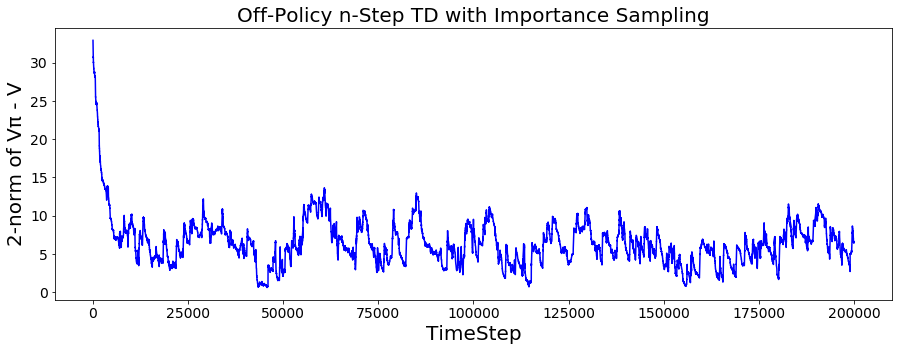

Value Function:   [ 8.93947142  9.06314182 10.87953598  8.95195854  8.94061189  8.02869202
  6.6542757   9.33664549  7.1875351   9.32164584]

Minimum Delta:   0.6282044115998803
explored states:  defaultdict(<class 'int'>, {2: 19310, 7: 42550, 1: 12438, 0: 15552, 3: 10480, 8: 15874, 4: 31049, 6: 25357, 5: 15939, 9: 11451})



With Diminishing Step Size
MDP with 10 states and 2 actions
discounting factor gamma = 0.95, step size alpha = 0.01

Running  1000 episodes

The Policy is (state,action) = target probability    behavior probability
(0,0) = 0.4835164835164835      0.4351851851851852  (0,1) = 0.5164835164835165      0.5648148148148148  
(1,0) = 0.48854961832061067      0.423728813559322  (1,1) = 0.5114503816793893      0.576271186440678  
(2,0) = 0.881578947368421      0.5714285714285714  (2,1) = 0.11842105263157894      0.42857142857142855  
(3,0) = 0.7980769230769231      0.1  (3,1) = 0.20192307692307693      0.9  
(4,0) = 0.2926829268292683      0.49382716049382713  (4,1) = 0.707

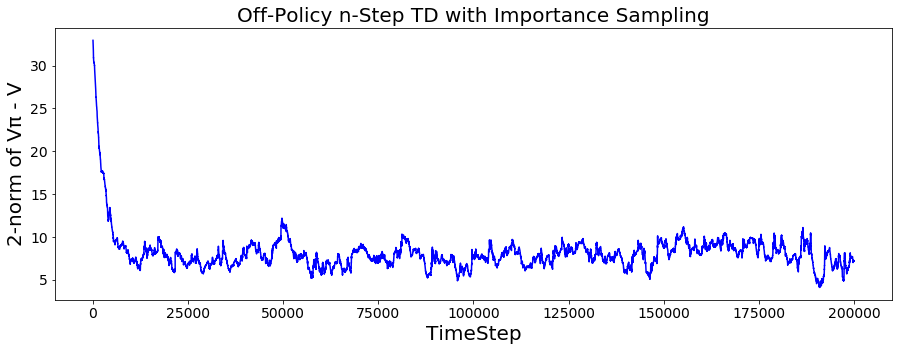

Value Function:   [8.59601037 7.94854216 8.1291498  7.60012226 8.12196949 8.08757588
 8.4871083  8.20379136 8.36914495 8.10024927]

Minimum Delta:   4.080793014493353
explored states:  defaultdict(<class 'int'>, {9: 31237, 5: 17168, 2: 13655, 8: 24527, 0: 25405, 3: 22884, 4: 13104, 7: 17390, 1: 21184, 6: 13446})
n =  1
Minimum Delta:   5.230614181129092 


n =  2
Minimum Delta:   2.297664910715257 


n =  3
Minimum Delta:   0.5553335085651406 


n =  4
Minimum Delta:   0.7569468173566719 




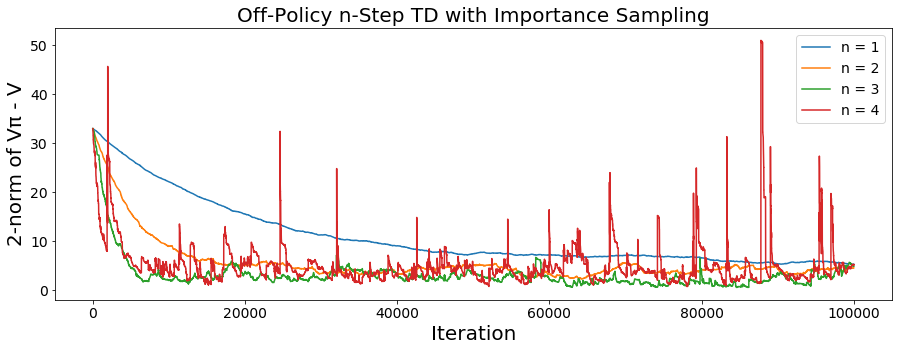

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import mdptoolbox.example
import random


class n_StepTDLearner:
    """
    Class that will ues on policy temporal difference
    prediction to solve the model free problem with a given policy

    """

    def __init__(self, target_policy, behavior_policy, states, actions, alpha=0.01, gamma=0.95, beta = 0.5, diminish = None, episodes=1000, timesteps = 200,n_step= 5):
        #action value function, mapping each state action pair
        #initialized to have 0 for every new state action pair
        self.value_function = np.zeros(states)

        #step size between [0,1]
        self.alpha = alpha
        self.gamma = gamma

        #the mapping of states to actions
        self.target_policy = target_policy
        self.behavior_policy = behavior_policy

        #the amount of states and actions
        self.states = states
        self.actions = actions
        #state space S
        self.state_space = np.arange(0,self.states)
        #action space A
        self.action_space = np.arange(0,self.actions)

        #transition probability matrix P, with shape AxSxS'
        self.transitionProbabilities, self.rewardMatrix = mdptoolbox.example.rand(states,actions)
        
        #the reward matrix
        self.rewardMatrix = np.random.rand(actions,states,states)

        #transition probability matrix under policy pi
        self.probabilityMatrix = np.zeros((self.states,self.states))
                
        
        #using behavior policy to forming it into a matrix
        self.policyMatrix = []
        for a, p in self.behavior_policy.items():
            self.policyMatrix.append(p)

        
        #only for diminishing step size using alpha and beta
        self.diminish = diminish
        self.step_size = self.alpha
        self.beta = beta
        
        #amount of episodes to run the environment for
        self.episodes = episodes
        #max time steps in an episode
        self.T = timesteps
        
        #keeps track of the amount of times the states have been visited
        self.exploringStates = defaultdict(int)
        
        #estimated v_pi, using value iteration
        self.v_pi = [10.3269891,10.28997413, 10.61215495, 10.47182536, 10.53804012, 10.44741659, 10.58984017, 10.28781177, 10.42280426, 10.27326007]
        
        #save the difference between v_pi and v
        self.difference= []
        
        #n step trajecrtory you would like to 
        self.n = n_step
    
    def setVpi(self,v_pi):
        """
        Set the estimated v_pi to what you found
        Must be called before running the environment
        Default reward matrix is set to what was found in value iteration
        
        For this to work
        :param v_pi: estimated v_pi, needs to be in length of state space S
        :returns: void
        """
        self.v_pi = v_pi  
        
    
    def setRewardMatrix(self,matrix):
        """
        Change the reward matrix to whatever you want with this function
        Must be called before running the environment
        Default reward matrix is set to random values between [0,1]
        
        For this to work
        Matrix needs to be in shape AxSxS
        A is the Action space
        S is the State space
        
        :param matrix: the reward matrix of choice
        :return: void
        """
        self.rewardMatrix = matrix
        
    def createProbabilityMatrix(self):
        
        #to run TD, the transition probability matrix has to be under the policy 
        #taking the sum of the probabilities of taking that action a under state s and multiplying that by the transition probability value 
        
        for s in range(self.states):
            probabilities = np.zeros(self.states)
            for a in range(self.actions):
                    action_prob = self.behavior_policy[s][a]
                    probabilities += self.transitionProbabilities[a][s]*action_prob
            self.probabilityMatrix[s] = probabilities
            

    def getNextState(self, state, action):
        """
        Just return the next state based on the transition probability matrix and the action taken
        Using random choice that will use a distribution to give a state
        :param state: observation that was previously seen
        :param action: action that was take
        :return: next state that the agent will go to 
        """
            
        next_state = np.random.choice(self.state_space,1,p = self.probabilityMatrix[state])
        return next_state[0]
    
    def chooseAction(self, state):
        """
        Using the current state and the given policy find the action  using random choice based on the probabilities
        :return: action 
        """
        
        p = []
        for action,prob in sorted(self.behavior_policy[state].items()):
            p.append(prob)
            
        action = np.random.choice(self.action_space, 1, p = p)
        
        return action[0] 

    def takeAction(self,state,action):
        
        """
        Perform the action on the environment and see the observation
        :param state: current state
        :param action: the action taken at state 
        :return: next state S' , reward R
        state sucessor and the reward observed
        """
        
        next_state = self.getNextState(state,action)
        reward = self.rewardMatrix[action][state][next_state]
        
        return next_state, reward
    
    def TDupdate(self):
        """
        Need to use episodes because otherwise it doesn't explore since my ploicy is not e-greedy
        Using the puesdo-code in Sutton and Barto doing the n-step TD Bootstrapping to predict Vπ
        
        the V(S) function update is
        V(s') = V(s) + αρt:t+n−1[Gt:t+n - V(s)]
        """
        
        states = []
        rewards = [0]
        actions = []
        
        #starting initial state
        state = np.random.randint(0,self.states)
        states.append(state)
        t = 0
        while True:
            
            if t<self.T:
                action = self.chooseAction(state)
                actions.append(action)
                next_state,reward = self.takeAction(state,action)
                states.append(next_state)
                self.exploringStates[next_state]+=1
                rewards.append(reward)
                
                
            tau = t-self.n+1
            if tau>=0:
                rho = 1
                G = 0
                #get importance sampling ratio
                for i in range(tau+1,min(tau+self.n,self.T)):
                    rho*= self.target_policy[states[i]][actions[i]]/ self.behavior_policy[states[i]][actions[i]]
                    
                #get truncated return value after n steps
                G = sum([(self.gamma**(i-tau-1))*rewards[i] for i in range(tau+1,min(tau+self.n+1,self.T+1))])
                
                if tau+self.n < self.T:
                    G += (self.gamma**self.n) * self.value_function[states[tau+self.n]]
                    
                #update the value function
                self.value_function[states[tau]] += self.step_size*rho*(G - self.value_function[states[tau]])
                
                #calculate the difference
                self.difference.append(np.linalg.norm(self.v_pi - self.value_function))
                
            if tau==self.T-1:
                break
                
            t+=1
        

    def runEnvironment(self):
        """
        Will run the OpenGym AI environment set using on policy Temporal Difference Learning

        :return: difference list between v_pi and v
        
        Rough Estimate of the Value Function Limit
        [10.3269891,10.28997413, 10.61215495, 10.47182536, 10.53804012, 10.44741659, 10.58984017, 10.28781177, 10.42280426, 10.27326007]

        """
        
        #create the transition probability matrix given the policy pi
        self.createProbabilityMatrix()
        for i in range(self.episodes):
            self.TDupdate()
                
        return self.difference      
    
    def plot(self):
        """
        Will plot the 2-norm difference found and more information on the results
        For debugging purposes
        """
        
        #info on the MDP
        print(f"MDP with {self.states} states and {self.actions} actions\ndiscounting factor gamma = {self.gamma}, step size alpha = {self.step_size}\n")
        print("Running ", self.episodes, "episodes")
        
        #info on the policy
        print("\nThe Policy is (state,action) = target probability    behavior probability")
        for s in range(self.states):
            for a in range(self.actions):
                print(f"({s},{a}) = {self.target_policy[s][a]}      {self.behavior_policy[s][a]} ",end=" ")
            print()
                      
        
        #plot the difference between v-pi and v
        plt.figure(figsize=(15,5))
        plt.plot(range(len(self.difference)), self.difference, 'b-')
        plt.title("Off-Policy n-Step TD with Importance Sampling",fontsize = 20)
        plt.xlabel("TimeStep",fontsize = 20)
        plt.ylabel("2-norm of Vπ - V",fontsize = 20)
        plt.xticks(fontsize = 14)
        plt.yticks(fontsize = 14)
        plt.show()
        
        #info on the value function
        print("Value Function:  ", self.value_function)
        print("\nMinimum Delta:  ", min(self.difference))
        print("explored states: ", self.exploringStates)

if __name__ == '__main__':
    
    
     
    """
    The Main Function to Run your program
    Example code given below
    All hyperparameters can be adjusted to your liking
    
    
    Policy must be given  
    the policy will be in the format of 
    (state,action) = Probability
    
    in python code it will be a dictionary inside of a dictionary
    {state: {action: probability of that action, action: probabiity, ... } state:{...}}
    """

    np.random.seed(0)
    target_policy = {0: {0: 0.4835164835164835, 1: 0.5164835164835165}, 1: {0: 0.48854961832061067, 1: 0.5114503816793893}, 2: {0: 0.881578947368421, 1: 0.11842105263157894}, 3: {0: 0.7980769230769231, 1: 0.20192307692307693}, 4: {0: 0.2926829268292683, 1: 0.7073170731707317}, 5: {0: 0.4430379746835443, 1: 0.5569620253164557}, 6: {0: 0.88, 1: 0.12}, 7: {0: 0.4715447154471545, 1: 0.5284552845528455}, 8: {0: 0.30952380952380953, 1: 0.6904761904761905}, 9: {0: 0.34328358208955223, 1: 0.6567164179104478}}
    behavior_policy = {0: {0: 0.4351851851851852, 1: 0.5648148148148148}, 1: {0: 0.423728813559322, 1: 0.576271186440678}, 2: {0: 0.5714285714285714, 1: 0.42857142857142855}, 3: {0: 0.1, 1: 0.9}, 4: {0: 0.49382716049382713, 1: 0.5061728395061729}, 5: {0: 0.2824427480916031, 1: 0.7175572519083969}, 6: {0: 0.42168674698795183, 1: 0.5783132530120482}, 7: {0: 0.1, 1: 0.9}, 8: {0: 0.8636363636363636, 1: 0.13636363636363635}, 9: {0: 0.3401360544217687, 1: 0.6598639455782312}}
    states = 10
    actions = 2
    
    
    print("With Constant Step Size\n\n")
    learner = n_StepTDLearner(target_policy = target_policy,behavior_policy = behavior_policy,states = states, actions = actions,episodes = 1000, n_step = 3)
    learner.runEnvironment()
    learner.plot()
    
    
    print("\n\n\nWith Diminishing Step Size")
    learner = n_StepTDLearner(target_policy = target_policy,behavior_policy = behavior_policy,states = states, actions = actions,episodes = 1000, diminish = lambda a,k,b: a/(k**b), n_step = 3)
    learner.runEnvironment()
    learner.plot()
    
    
    #running multiple n-steps and plotting them on the same graph
    plt.figure(figsize = (15,5))
    for n in range(1,5):
        learner = n_StepTDLearner(target_policy = target_policy,behavior_policy = behavior_policy,states = 10, actions = 2,episodes = 500, n_step = n)
        graph = learner.runEnvironment()
        print("n = ", n)
        plt.plot(range(len(graph)), graph, label = f"n = {n}")
        print("Minimum Delta:  ", min(graph),"\n\n")
    plt.xlabel("Iteration",fontsize = 20)
    plt.ylabel("2-norm of Vπ - V",fontsize = 20)
    plt.title("Off-Policy n-Step TD with Importance Sampling",fontsize = 20)
    plt.legend(fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.show()


